# ESM3 Sample Loading
The purpose of this notebook is to load samples from ESM data into a file to be used as training data for GMM. The samples were created in GMMSampleCreator. Link to [Data analysis](#Data-Analysis).<br>
This notebook is saved as a proof of concept and to be available for future testing and modification.

#### Dask

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35601")
client

Client Scheduler: tcp://127.0.0.1:35601 Dashboard: http://127.0.0.1:45432/status,Cluster Workers: 9 Cores: 9 Memory: 57.98 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = slice(0, 2000) #Selected levels to be investigated
maskName = "OceanMaskESM2"
lastESMDecade = slice('2005-01','2014-12')
sampleFileName = "GMMSampleTimeGeo2.npy"

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading ESM data</b>

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]

zstore = dfFilt.zstore.values[0] #Opens first file only
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.thetao.sel(lat=latSel) #Selection of latitude
#dfESMLatLev = dfESMLat
dfESMLatLev = dfESMLat.sel(lev=levSel) #Selects level data down to 2k
dfESMLatLevT = dfESMLatLev.sel(time=lastESMDecade)
dfESMLatLevT = dfESMLatLevT.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLatLevT["time"][0].values
globalDateInc = dfESMLatLevT["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLatLevT["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM3 data loaded and stored in dfESMLatLevT")
#dfESMLatLevT #Uncomment to see data set

ESM3 data loaded and stored in dfESMLatLevT


<br>
<b>Calculating depth axis</b>

In [5]:
depthAxis = np.array(dfESMLatLevT.lev)
print("Depth axis calculated")

Depth axis calculated


<br>
<b>Loading ocean mask</b>

In [6]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Loading sample time and geo data</b>

In [7]:
sampleDataPoints = np.load(sampleFileName, allow_pickle=True)
print("GMM sample time and geo data loaded into sampleDataPoints")

GMM sample time and geo data loaded into sampleDataPoints


<br>

<br>
<b>Placing valid locations into an array</b><br>
Ocean mask here is used as it was generated from ESM3 data, however it would be more accurate to use the ESM sample data straight.

In [8]:
geoRangeLat = np.empty(shape=(0))
geoRangeLon = np.empty(shape=(0))
for i in range(61):
    for j in range(360):
        if not np.isnan(oceanMask[0][i][j]):
            geoRangeLat = np.append(geoRangeLat, oceanMask.lat[i])
            geoRangeLon = np.append(geoRangeLon, oceanMask.lon[j])
geoRange = np.append([geoRangeLat], [geoRangeLon], axis = 0) #Merges lat and lon arrays together into singular array
print("Valid locations identified and stored in geoRange")
#geoRange #Uncomment to see data array

Valid locations identified and stored in geoRange


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
</ul>

In [9]:
print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
<li>locationPlotSimple - Plots locations of an input data array on a map.
<li>locationPlot - Plots locations of an input data array on a map with a colour scale for time.
<li>latDistribution - Plots latitude distribution of an input data array as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data arrays against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data array as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data arrays against each other as histograms.
<li>timeDistribution - Plots time distribution of an input data array as a histogram.
<li>tempPointPlot - Plots the temperature profile of a single point against depth.
</ul>

In [10]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))
    
def locationPlotSimple(dataArray, size, plotNo):
    '''Plots locations of numpy arrays'''
    colours = {"2005":"Red", "2006":"Blue"}
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    plt.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), color = "Red")
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlot(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def latDistribution(dataArray, binSize, plotNo):
    '''Plots latitude distribution of input data array'''
    if not binSize: binSize = 2
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, binSize)
    plt.hist(dataArray[0], bins = latDistri)
    plt.title("Latitude distribution of data points (Bin size:"+str(binSize)+")")
    
def latDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares latitude distribution of input data arrays'''
    if not binSize: binSize = 2
    plt.figure(plotNo, figsize=(10,7))
    latDistri = np.arange(-89.5, -29.4, binSize)
    latWeightsS = np.ones_like(dataArrayS[0])/float(len(dataArrayS[0]))
    latWeightsO = np.ones_like(dataArrayO[0])/float(len(dataArrayO[0]))
    plt.hist(dataArrayS[0], bins = latDistri, weights = latWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[0], bins = latDistri, weights = latWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def lonDistribution(dataArray, binSize, plotNo):
    '''Plots longitude distribution of input data array'''
    if not binSize: binSize = 3
    plt.figure(plotNo)
    lonDistri = np.arange(0, 360.1, binSize)
    plt.hist(dataArray[1], bins = lonDistri)
    plt.title("Longitude distribution of data points (Bin size:"+str(binSize)+")")
    
def lonDistributionCompare(dataArrayS, dataArrayO, binSize, plotNo):
    '''Plots and compares longitude distribution of input data arrays'''
    if not binSize: binSize = 3
    plt.figure(plotNo, figsize=(10,7))
    lonDistri = np.arange(0, 360.1, binSize)
    lonWeightsS = np.ones_like(dataArrayS[1])/float(len(dataArrayS[1]))
    lonWeightsO = np.ones_like(dataArrayO[1])/float(len(dataArrayO[1]))
    plt.hist(dataArrayS[1], bins = lonDistri, weights = lonWeightsS, alpha=0.5, label="Sampled data")
    plt.hist(dataArrayO[1], bins = lonDistri, weights = lonWeightsO, alpha=0.5, label="Original data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to original data set distribution (Bin size:"+str(binSize)+")")
    
def timeDistribution(dataArray, plotNo):
    plt.figure(plotNo)
    timeDistri = np.arange(np.datetime64("2005-01", "M"), np.datetime64("2015-02", "M")) #last date is excluded (max "2015-01"), 2014-12 needs monthly bin
    plt.hist(dataArray[2], bins = timeDistri)
    plt.title("Time distribution of data points")
    
def tempPointPlot(dataArray, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, depthAxis)
    plt.title(str(title))
    plt.gca().invert_yaxis()

print("Plotting functions defined")

Plotting functions defined


<br>

#### Displaying the mask

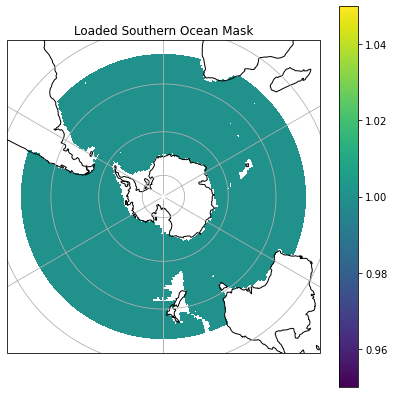

In [11]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Loaded Samples time and geo properties

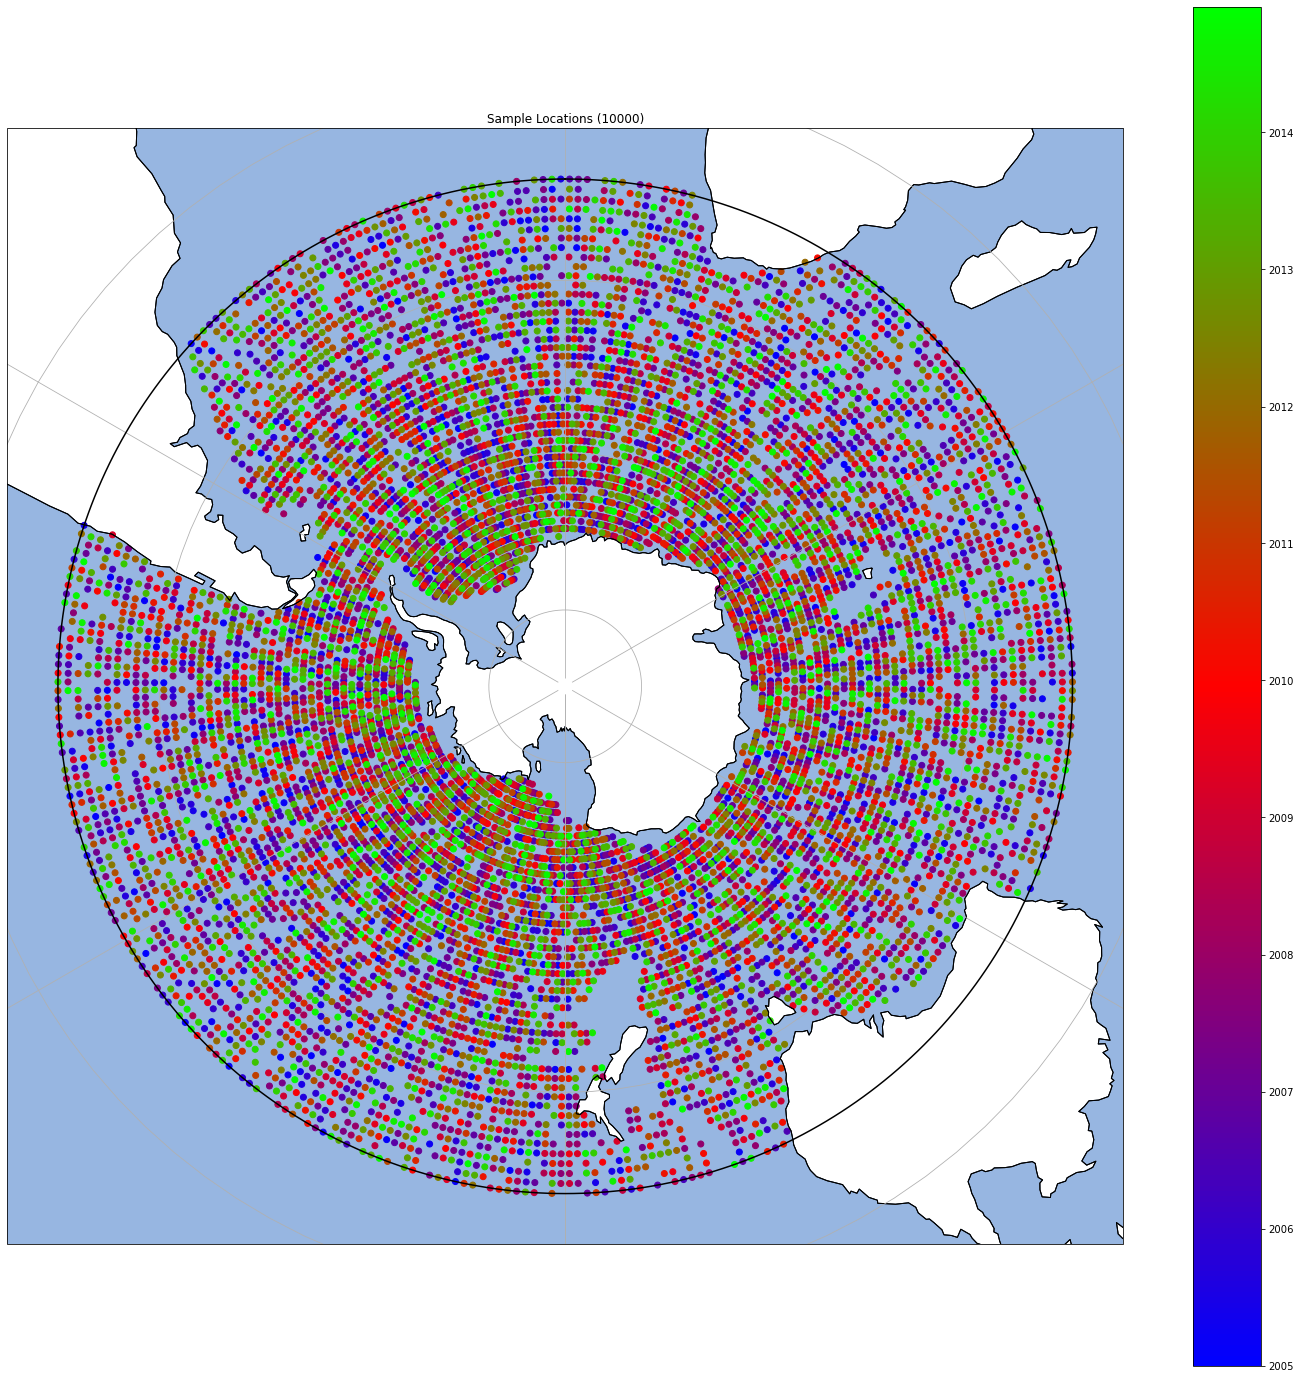

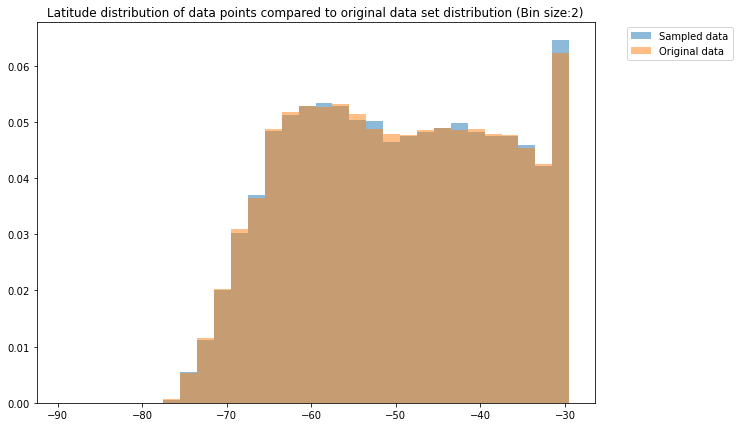

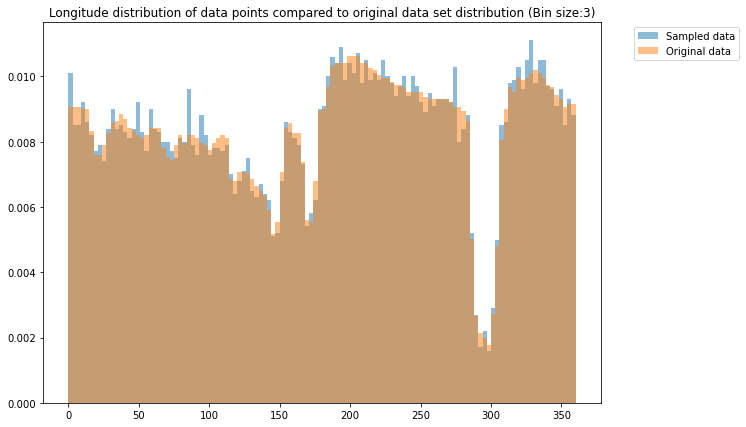

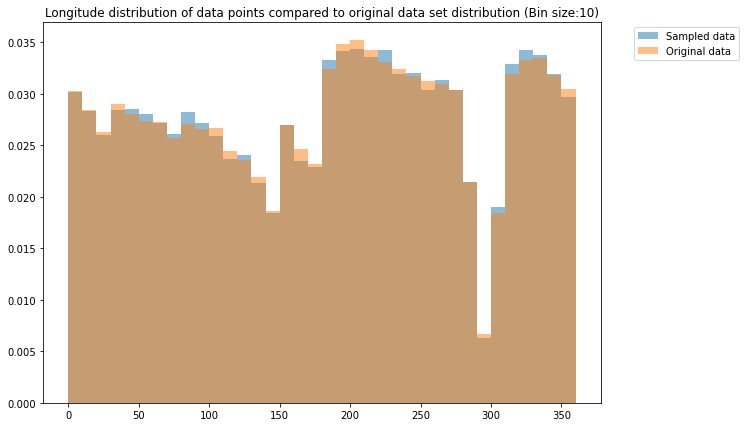

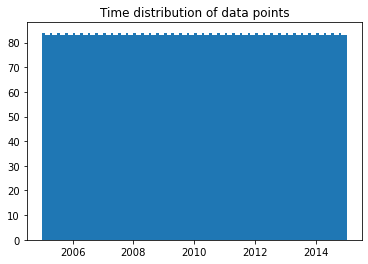

In [12]:
locationPlot(sampleDataPoints, (25,25), 1)
latDistributionCompare(sampleDataPoints, geoRange, 2, 2)
lonDistributionCompare(sampleDataPoints, geoRange, 3, 3)
lonDistributionCompare(sampleDataPoints, geoRange, 10, 4)
timeDistribution(sampleDataPoints, 5)

<br>

#### Data Analysis
<b>Extraction speed comparison</b><br>
Comparing to see if extraction is faster with or without cleaning sample coordinates.

In [13]:
i = np.random.randint(20)
print(i)
sample = dfESMLatLevT.sel(lat=sampleDataPoints[0][i], lon=sampleDataPoints[1][i], time=np.datetime64(sampleDataPoints[2][i]))

19


In [14]:
%%time
sampleTemp = np.array(sample.values)

CPU times: user 299 ms, sys: 32.4 ms, total: 331 ms
Wall time: 18.2 s


In [15]:
%%time
sampleClean = sample.reset_coords(drop=True)
sampleTemp = np.array(sampleClean.values)

CPU times: user 14.1 ms, sys: 5.15 ms, total: 19.3 ms
Wall time: 3.6 s


<br>
<b>Extraction</b>

In [16]:
@delayed
def extract(i):
    sample = dfESMLatLevT.sel(lat=sampleDataPoints[0][i], lon=sampleDataPoints[1][i], time=np.datetime64(sampleDataPoints[2][i]))
    sampleClean = sample.reset_coords(drop=True)
    sampleTemp = np.array(sampleClean.values)
    return sampleTemp

In [17]:
%%time
sampleTempArray = np.empty(shape=(0,46))
for i in range(5):
    sampleTemp = extract(i)
    sampleTempArray = np.append(sampleTempArray, [sampleTemp], axis = 0)
sampleTempArray = sampleTempArray.compute()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [18]:
%%time
sampleTempArray = np.empty(shape=(0,46))

for i in range(5):
    sample = dfESMLatLevT.sel(lat=sampleDataPoints[0][i], lon=sampleDataPoints[1][i], time=np.datetime64(sampleDataPoints[2][i]))
    sampleClean = sample.reset_coords(drop=True)
    sampleTemp = np.array(sampleClean.values)
    sampleTempArray = np.append(sampleTempArray, [sampleTemp], axis = 0)

CPU times: user 85.4 ms, sys: 8.86 ms, total: 94.3 ms
Wall time: 17.2 s


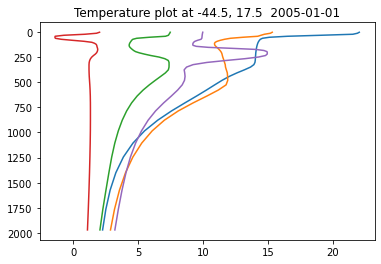

In [19]:
for j in range(5):
    tempPointPlot(sampleTempArray[j], "Temperature plot at "+str(sampleDataPoints[0][j])+", "+str(sampleDataPoints[1][j])+"  "+str(sampleDataPoints[2][j]), 1)

In [20]:
exportFileName = sampleFileName[:9]+"Data"+sampleFileName[-5:-4]
np.save(exportFileName, sampleTempArray)

In [21]:
reloadSampleTempArray = np.load(exportFileName+".npy")

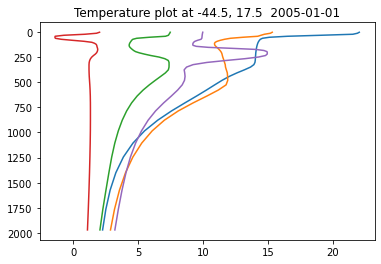

In [22]:
for j in range(5):
    tempPointPlot(reloadSampleTempArray[j], "Temperature plot at "+str(sampleDataPoints[0][j])+", "+str(sampleDataPoints[1][j])+"  "+str(sampleDataPoints[2][j]), 1)